# 05 Flood mapping with Sentinel-1

## Quick link
 
* [Objective](#objective)
* [Test Site](#test-site)
* [Context](#context)
* [Applicability](#applicability)
* [Data](#data)
* [Workflow](#workflow)
 * [Step 0: Data preparation](#subset)
 * [Step 1: Pre-processing - Calibration](#calibrate)
 * [Step 2: Pre-processing - Speckle filtering](#speckle)
 * [Step 3: Binarization](#binarization)
 * [Step 4: Post-processing - Geometric correction](#terrain)
* [Strengths and Limitations](#strengths-limitations) 
* [License](#license)

## <a name="objective">Objective 

The objective of this practice is to determine the extent of flooded areas. The use of SAR satellite imagery for flood extent mapping constitutes a viable solution to process images quickly, providing near real-time flooding information to relief agencies. Moreover, flood extent information can be used for damage assessment and risk management creating scenarios showing potential population, economic activities and the environment at potential risk from flooding,

## <a name="testsite">Test Site

Malawi

## <a name="context">Context

The practice was applied to the flood event in Malawi in January 2015. Since December 2014, heavy rains affected Malawi causing rivers to overflow. The recommended practices was applied to an affected area in the Nsanje district around Chiromo.

## <a name="applicability">Applicability

This practice can be applied globally. It has been applied successfully for floods in Australia, Africa and Asia. Precondition for SAR water detection is a smooth water surface. False alarm can occur in areas of radar shadow due to variable terrain. False alarm can also occur with smooth objects like roads and sand. Flood detection in urban areas remains difficult. The detection of flooded vegetation from SAR imagery requires a different approach using two multi-temporal images.


## <a name="data">Data

SENTINEL data products are made available systematically and free of charge to all data users including the general public, scientific and commercial users. Radar data will be delivered within an hour of reception for Near Real-Time (NRT) emergency response, within three hours for NRT priority areas and within 24 hours for systematically archived data.

All data products are distributed in the SENTINEL Standard Archive Format for Europe (SAFE) format.

Data products are available in single polarisation (VV or HH) for Wave mode and dual polarisation (VV+VH or HH+HV) and single polarisation (HH or VV) for SM, IW and EW modes.

Level-1 Ground Range Detected (GRD) products consist of focused SAR data that has been detected, multi-looked and projected to ground range using an Earth ellipsoid model. Phase information is lost. The resulting product has approximately square resolution pixels and square pixel spacing with reduced speckle at the cost of reduced geometric resolution.

GRD products can be in one of three resolutions:

* Full Resolution (FR)
* High Resolution (HR)
* Medium Resolution (MR).

The resolution is dependent upon the amount of multi-looking performed. Level-1 GRD products are available in MR and HR for IW and EW modes, MR for WV mode and MR, HR and FR for SM mode.

## <a name="data">Let's get the work done

Define the product to process:

In [1]:
s1path = "S1A_IW_GRDH_1SSV_20150122T030723_20150122T030752_004278_005347_8809"

In [2]:
from snappy import jpy
from snappy import ProductIO

s1meta = "manifest.safe"
s1prd = "/workspace/data/%s/%s.SAFE/%s" % (s1path, s1path, s1meta)
reader = ProductIO.getProductReader("SENTINEL-1")
product = reader.readProductNodes(s1prd, None)

Extract information about the Sentinel-1 GRD product:

In [3]:
width = product.getSceneRasterWidth()
height = product.getSceneRasterHeight()
name = product.getName()
band_names = product.getBandNames()

In [4]:
print("Product: %s, %d x %d pixels" % (name, width, height))
print("Bands:   %s" % (list(band_names)))

Product: S1A_IW_GRDH_1SSV_20150122T030723_20150122T030752_004278_005347_8809, 25645 x 19520 pixels
Bands:   ['Amplitude_VV', 'Intensity_VV']


## <a name="workflow">Workflow

* Step 0: Data preparation - Subset
* Step 1: Pre-processing - Calibration
* Step 2: Pre-processing - Speckle filtering
* Step 3: Binarization
* Step 4: Post-processing - Geometric correction


### <a name="subset">Step 0: Data preparation - Subset

We extract a subset of the Sentinel-1 GRD product by specify a rectangle:

In [5]:
from snappy import GPF
from snappy import HashMap

x = 18727
y = 15438
width = 6186
height = 3942

HashMap = jpy.get_type('java.util.HashMap')    
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

parameters = HashMap()
parameters.put('copyMetadata', True)
parameters.put('region', "%s,%s,%s,%s" % (x, y, width, height))
subset = GPF.createProduct('Subset', parameters, product)

In [6]:
print("Bands:   %s" % (list(subset.getBandNames())))

Bands:   ['Amplitude_VV', 'Intensity_VV']


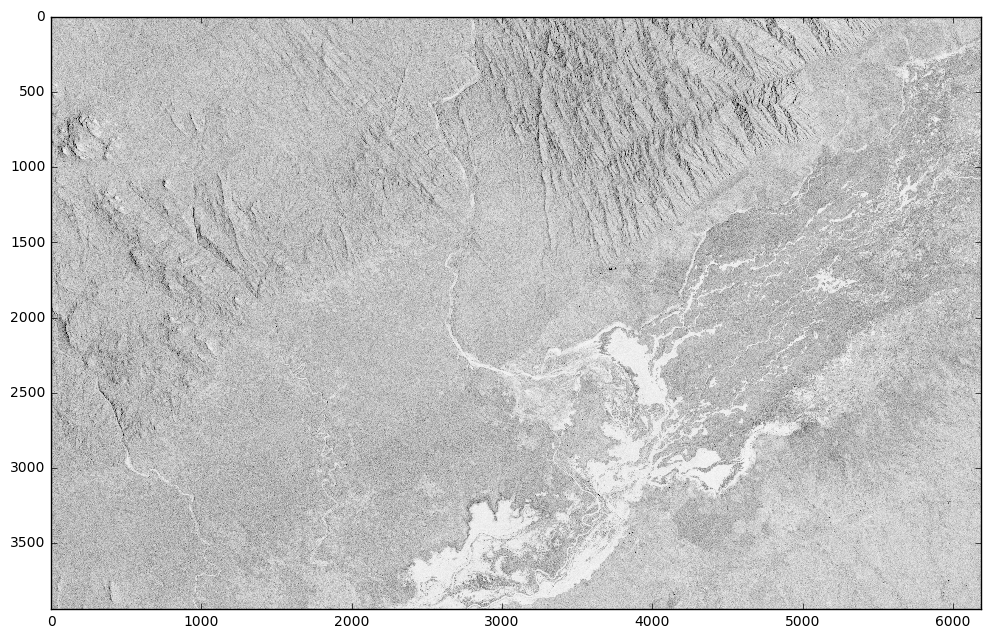

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline

def plotBand(product, band, vmin, vmax):
     
    band = product.getBand(band)

    w = band.getRasterWidth()
    h = band.getRasterHeight()

    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)

    band_data.shape = h, w

    width = 12
    height = 12
    plt.figure(figsize=(width, height))
    imgplot = plt.imshow(band_data, cmap=plt.cm.binary, vmin=vmin, vmax=vmax)
    
    return imgplot 

plotBand(subset, 'Amplitude_VV', 0, 750)

### <a name="calibration">Step 1: Pre-processing - Calibration

The objective of SAR calibration is to provide imagery in which the pixel values can be directly related to the radar backscatter of the scene. Though uncalibrated SAR imagery is sufficient for qualitative use, calibrated SAR images are essential to quantitative use of SAR data.

Typical SAR data processing, which produces level 1 images, does not include radiometric corrections and significant radiometric bias remains. Therefore, it is necessary to apply the radiometric correction to SAR images so that the pixel values of the SAR images truly represent the radar backscatter of the reflecting surface. The radiometric correction is also necessary for the comparison of SAR images acquired with different sensors, or acquired from the same sensor but at different times, in different modes, or processed by different processors.

In [8]:
parameters = HashMap()

parameters.put('auxFile', 'Latest Auxiliary File')
parameters.put('outputSigmaBand', True)
parameters.put('selectedPolarisations', 'VV')

calibrate = GPF.createProduct('Calibration', parameters, subset)

In [9]:
list(calibrate.getBandNames())

['Sigma0_VV']

### <a name="speckle">Step 2: Pre-processing - Speckle filtering

SAR images have inherent salt and pepper like texturing called speckles which degrade the quality of the image and make interpretation of features more difficult. Speckles are caused by random constructive and destructive interference of the de-phased but coherent return waves scattered by the elementary scatters within each resolution cell. Speckle noise reduction can be applied either by spatial filtering or multilook processing. 

In [10]:
parameters = HashMap()

parameters.put('filter', 'Lee')
parameters.put('filterSizeX', 7)
parameters.put('filterSizeY', 7)
parameters.put('dampingFactor', 2)
parameters.put('edgeThreshold', 5000.0)
parameters.put('estimateENL', True)
parameters.put('enl', 1.0)

speckle = GPF.createProduct('Speckle-Filter', parameters, calibrate)

In [11]:
band_names = speckle.getBandNames()

In [12]:
print(list(band_names))

['Sigma0_VV']


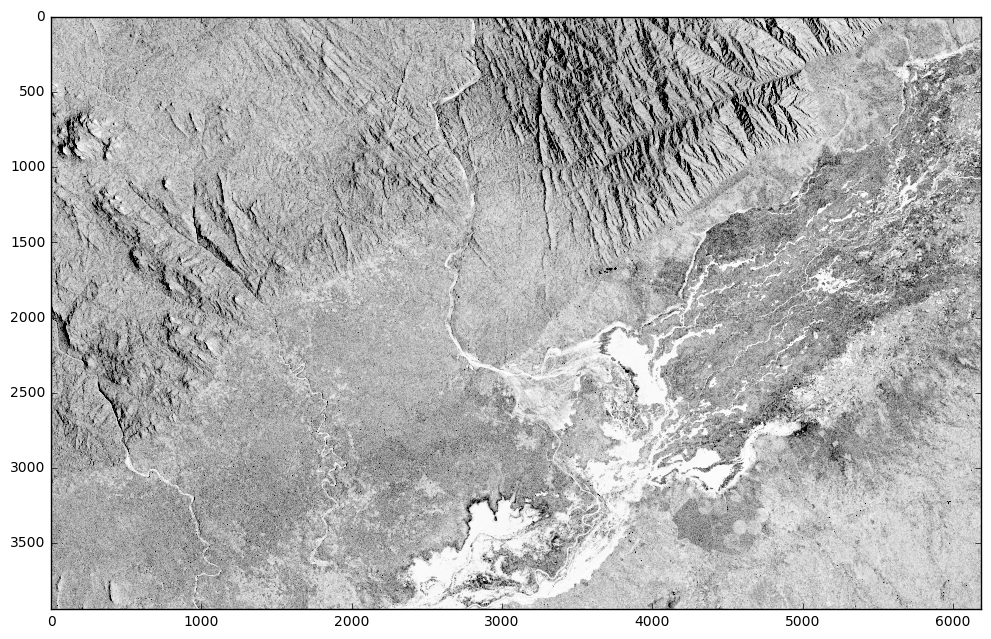

In [13]:
plotBand(speckle, 'Sigma0_VV', 0, 0.3)

### <a name="binarization">Step 3: Binarization

To separate water from non-water a threshold can be selected. For this, we will analyse the histogram of the filtered backscatter coefficient. On the left side panel select the Colour Manipulation tab. The histogram of the backscatter coefficient will show up and one might need to use the logarithmic display. The histogram will show one or more peaks of different magnitude depending on the data. Low values of the backscatter will correspond to the water, and high values will correspond to the non-water class. 

Plot the histogram of the filtered data to detect the water threshold:

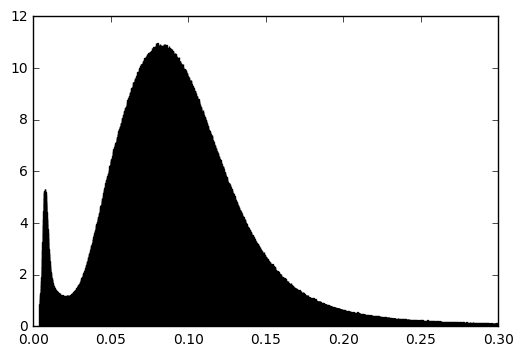

In [14]:
import math
band = speckle.getBand('Sigma0_VV')

w = band.getRasterWidth()
h = band.getRasterHeight()

band_data = np.zeros(w * h, np.float32)
band.readPixels(0, 0, w, h, band_data)
band_data.shape = h * w

plt.hist(np.asarray(band_data, dtype='float'), bins=2048, range=[0.004, 0.3], normed=True)

plt.show()

We need to select the value that will separate water from non-water. In our case, the threshold value will be 0.025.

In [15]:
threshold = 0.025 

In [16]:
expression = "Sigma0_VV < %s" % threshold

BandDescriptor = jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')

targetBand = BandDescriptor()
targetBand.name = 'flood'
targetBand.type = 'Float32'
targetBand.expression = expression

targetBands = jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 1)
targetBands[0] = targetBand

parameters = HashMap()
parameters.put('targetBands', targetBands)

flood = GPF.createProduct('BandMaths', parameters, speckle)

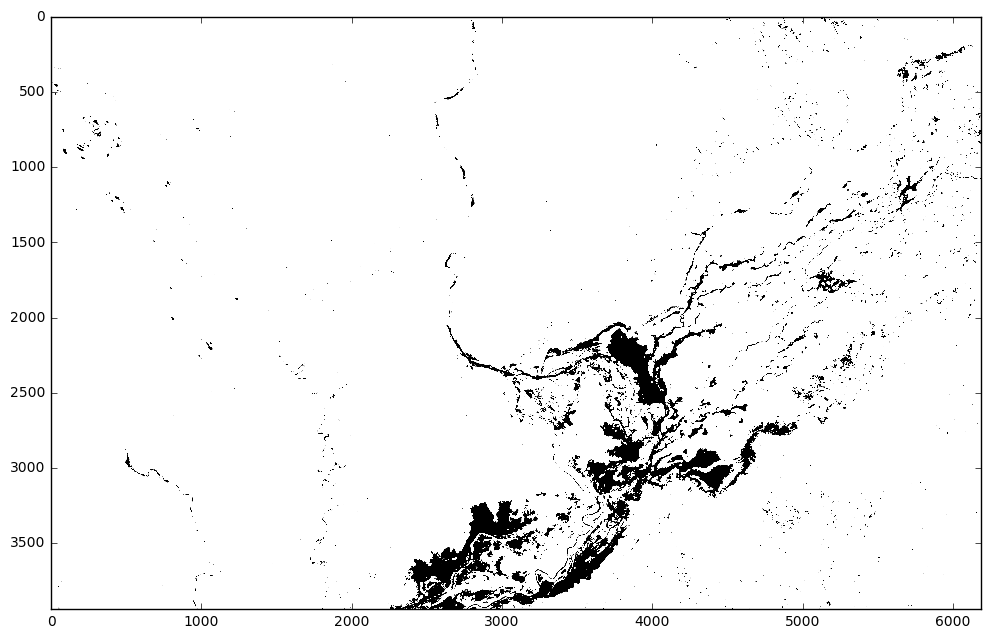

In [17]:
plotBand(flood, 'flood', 0, 1)

### <a name="terrain"> Step 4: Post-processing - Geometric correction

Due to topographical variations of a scene and the tilt of the satellite sensor, distances can be distorted in the SAR images. Image data not directly at the sensor’s Nadir location will have some distortion. Terrain corrections are intended to compensate for these distortions so that the geometric representation of the image will be as close as possible to the real world.

The Range Doppler Terrain Correction Operator implements the Range Doppler orthorectification method for geocoding SAR images from single 2D raster radar geometry. It uses available orbit state vector information in the metadata or external precise orbit, the radar timing annotations, the slant to ground range conversion parameters together with the reference DEM data to derive the precise geolocation information. 

In [18]:
parameters = HashMap()

parameters.put('demName', 'SRTM 3Sec')
parameters.put('externalDEMNoDataValue', 0.0)
parameters.put('demResamplingMethod', "BILINEAR_INTERPOLATION")
parameters.put('imgResamplingMethod', "BILINEAR_INTERPOLATION")
parameters.put('pixelSpacingInMeter', 10.0)
parameters.put('pixelSpacingInDegree', 0.0)
parameters.put('mapProjection', "WGS84(DD)")

terrain = GPF.createProduct('Terrain-Correction', parameters, flood)

In [19]:
print("Bands:   %s" % (list(terrain.getBandNames())))

Bands:   ['flood_VV']


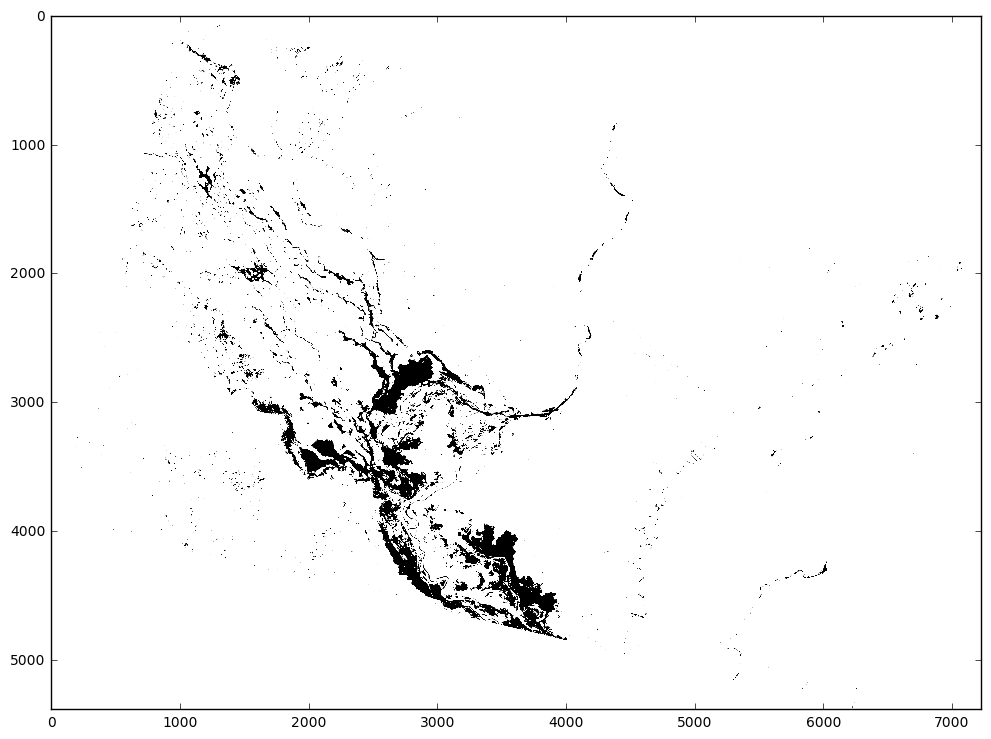

In [20]:
plotBand(terrain, 'flood_VV', 0, 1)

In [ ]:
ProductIO.writeProduct(terrain, 'output.tif', "Geotiff")

To download the file produced follow this [link](output.tif)

In [ ]:
from osgeo import gdal, ogr, osr

import sys

gdal.UseExceptions()
src_ds = gdal.Open("output.tif")

srcband = src_ds.GetRasterBand(1)

srs = osr.SpatialReference()
srs.ImportFromWkt(src_ds.GetProjectionRef())

dst_layername = "Malawi_flood_extent"
drv = ogr.GetDriverByName("ESRI Shapefile")
dst_ds = drv.CreateDataSource(dst_layername + ".shp" )
dst_layer = dst_ds.CreateLayer(dst_layername, srs = srs )

dst_fieldname = 'DN'

fd = ogr.FieldDefn( dst_fieldname, ogr.OFTInteger )
dst_layer.CreateField( fd )
dst_field = 0
gdal.Polygonize(srcband, srcband.GetMaskBand(), dst_layer, dst_field, [], callback=None )

To download the files produced follow the links:

* [Malawi_flood_extent.dbf](Malawi_flood_extent.dbf)
* [Malawi_flood_extent.shp](Malawi_flood_extent.shp)
* [Malawi_flood_extent.prj](Malawi_flood_extent.prj)
* [Malawi_flood_extent.shx](Malawi_flood_extent.shx)

## <a name="strengths-limitations"> Strengths and Limitations

The use of threshold method for SAR has the following advantages:

* Cloud independent SAR images.
* High revisit time.
* Easy detection of smooth water.
* Accuracy: up to 95% (depending on the landscape and area).

Limitations:

* Potential false alarm from shadows (variable terrain), smooth objects (like roads) and sand.
* Difficulties in detection floods in urban areas.
* Difficulties in detecting flooded vegetation. (For flooded vegetation detection from SAR usually two multi-temporal images are required.)

## <a name="license">License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.